**Problem 3**

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


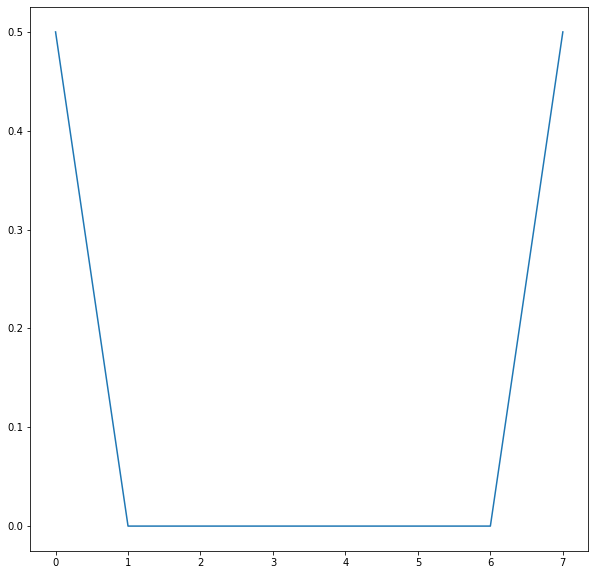

In [70]:

# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
import torch




"""
q = QuantumRegister(2)

qc = QuantumCircuit(q)
qc.u(pi,0,pi,q[0])
qc.draw()
"""


#lets create GHZ state
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)
state1 = state.copy()
# Evolve the state by the quantum circuit
state = state.evolve(circ)
print(state)
print(state1)

plt.plot(state.probabilities())

In [71]:
#function that apply the KS test to two probability list
def KS(P1, P2):
    assert len(P1) == len(P2)
    cdf1 = [P1[0]]
    cdf2 = [P2[0]]
    for i in range(len(P1)-1):
        cdf1.append(cdf1[i] + P1[i+1])
        cdf2.append(cdf2[i] + P2[i+1])
    difference = torch.tensor(cdf1) - torch.tensor(cdf2)
    #print(difference)
    return difference.abs().max().item()
"""
def KS(P1, P2):
    P1 = torch.tensor(P1)
    P2 = torch.tensor(P2)
    return torch.pow(P1 - P2, 2).sum() / P1.size(0)
"""
#print(KS([0.2, 0.8], [0.5, 0.5]))


def KL(P1, P2):
    Q = torch.tensor(P1)
    Q = Q + 0.00001 * torch.ones(Q.size())
    P = torch.tensor(P2)
    P = P + 0.00001 * torch.ones(Q.size())
    #print(Q)
    #tens = torch.div(P, Q)
    #tens = 
    return (torch.log(torch.div(P, Q)) * P).sum().item()

print(KL([0, 1], [0.5, 0.5]))




def gauss(x,y, s):
    return torch.exp(-torch.abs(torch.tensor(x-y))**2/(2*s**2))
def MMDLoss(sampX, sampY, s):
    '''Computing MMD loss out of samples'''
    mmd = 0
    if len(sampX)!=len(sampY): raise ValueError('Length of samples does not match')
    L=len(sampX)
    for i in range(L):
        for j in range(L):
            mmd += gauss(sampX[i], sampX[j], s)
            mmd += gauss(sampY[i], sampY[j], s)
            mmd -= 2*gauss(sampX[i], sampY[j], s)
    return mmd/L**2

import numpy as np
def mmdloss(P1, P2):
    #first create the list of probability distribution
    sample1 = np.random.choice(len(P1), size=100, p=P1)
    sample2 = np.random.choice(len(P2), size=100, p=P2)
    #print(sample1)
    #print(sample2)
    return MMDLoss(sample1, sample2, 1).item()

print(mmdloss([0,0, 1], [1,0, 0]))



5.063431739807129
1.7293943166732788


In [72]:
from torch.nn import functional as F
import torch.nn as nn

#This is our KS network duh
class KS_net(nn.Module):
    def __init__(self):
        super(KS_net, self).__init__()
        self.linear1 = nn.Linear(9, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 1)
    
    def forward(self, param):
        x = F.relu(self.linear1(param))
        #print(x)
        x = F.relu(self.linear2(x))
        #print(x)
        x = F.relu(self.linear3(x))
        return x

tensor([[0.0000, 0.0000, 0.0000],
        [0.3142, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [0.6283, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [0.9425, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [1.2566, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.0000, 0.0000, 0.0000],
        [1.5708, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])


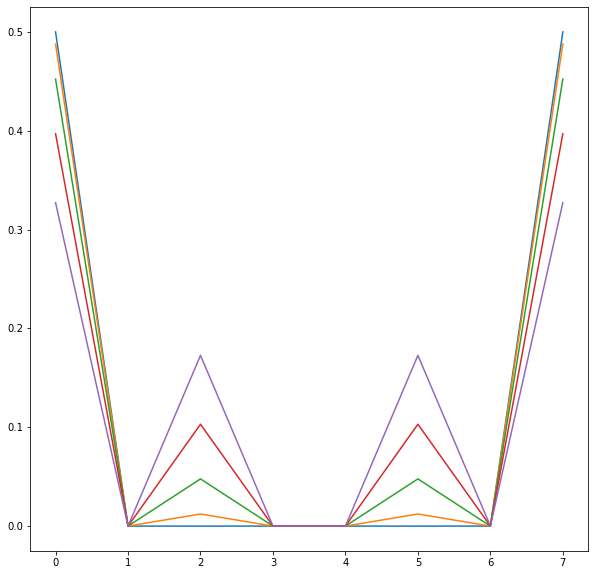

In [108]:
#we write two classes: one for generating the data and the other for learning
#This class generates the data (x,y), x is the transformation we apply and y is the KL value measured
#in the basis defined by the basis_param


import random

class DataGenerator:
  def __init__(self, new_basis_param):
    self.original_state = state
    self.prob_metric = KL
    self.basis_param = new_basis_param.clone()
    self.train_data = torch.zeros(3000, 10) #data for training KS_net, 9 + 1 = param + value
    self.train_data.requires_grad = False
    self.test_data = torch.zeros(500, 10)




  
  #return a transformed state according to parameter
  def transform(self, p):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    return self.original_state.copy().evolve(qc)

    
    
  def new_probabilities(self):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    p = self.basis_param
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    dum = self.original_state.copy().evolve(qc)
    return dum.probabilities()
    


  def change_basis(self, state1, state2):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    p = self.basis_param
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    return state1.copy().evolve(qc), state2.copy().evolve(qc)

  #return the loss from KS test of original vs another state
  def calculate_loss(self, state2, param):
    #get the probability in the original basis
    P1 = self.original_state.probabilities()
    P2 = state2.probabilities()
    #now we calculate probability in another basis
    new_state1, new_state2 = self.change_basis(self.original_state, state2)
    Q1 = new_state1.probabilities()
    Q2 = new_state2.probabilities()
    return [self.prob_metric(P1, P2) + 0 * self.prob_metric(Q1, Q2), 0 * self.prob_metric(P1, P2) + 1*self.prob_metric(Q1, Q2)]
  

  def generate_data(self):
    #generate the test data and train data
    for i in range(self.test_data.size(0)):
      parameters = torch.randint(0, 200, (3, 3)) * 2 * pi / 200
      #parameters[2:3, :] = torch.zeros(1,3)
      target = torch.tensor([self.calculate_loss(self.transform(parameters), parameters)[0]])
      self.test_data[i, 0:9] = parameters.view(9)
      self.test_data[i, 9] = target
    for i in range(self.train_data.size(0)):
      parameters = torch.randint(0, 200, (3, 3)) * 2 * pi / 200
      #parameters[2:3, :] = torch.zeros(1,3)
      target = torch.tensor([self.calculate_loss(self.transform(parameters), parameters)[0]])
      self.train_data[i, 0:9] = parameters.view(9)
      self.train_data[i, 9] = target




      


        
        
        

import numpy as np


#parameter = torch.tensor([[0,0,0,], [0*pi/10, 0,0], [0,0,0]])
parameter = torch.zeros(3,3)

for i in range(5):
  gen = DataGenerator(parameter)
  #print(gen.basis_param)
  parameter[1,0] = parameter[1,0] + pi/10
  print(parameter)
  
  plt.plot(gen.new_probabilities())



  

  
  
  

  


In [113]:
from torch.nn import functional as F
import torch.nn as nn

#This is our KS network duh
class KL_net(nn.Module):
    def __init__(self):
        super(KL_net, self).__init__()
        self.linear1 = nn.Linear(9, 30)
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 1)
    
    def forward(self, param):
        x = F.relu(self.linear1(param))
        #print(x)
        x = F.relu(self.linear2(x))
        #print(x)
        x = F.relu(self.linear3(x))
        return x

In [115]:
class Learner():
    def __init__(self, train_data, test_data, training_length, lr):
        self.train_data = train_data
        self.test_data = test_data
        self.learn_rate = lr #learning rate for training KL_net
        self.model = KL_net()
        self.batch_size = 20 #batch for SGD
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learn_rate)
        self.loss_func = nn.MSELoss()
        self.training_length = training_length #how many SGD to do
        self.losses = []
    

    def train(self):
    #this function use the data gathered to update KS_net parameters
        for i in range(self.training_length):
            self.optimizer.zero_grad()
            num = self.train_data.size(0)
            indices = random.sample(range(num), self.batch_size)
            sampled_data = self.train_data[indices].clone()
            target = sampled_data[:, 9] #actual KS_value
            current = self.model(sampled_data[:, 0:9]).squeeze()
            loss = self.loss_func(current, target)
            if i % 10 ==0:
                self.losses.append(loss.item())
            #print(loss)
            loss.backward()
            self.optimizer.step()
            if i % 100 == 0:
                print(i)
      
    def test_error(self):
        current = self.model(self.test_data[:, 0:9]).detach_()
        target = self.test_data[:, 9]
        return torch.pow(current- target, 2).sum() / current.size(0)
    







In [109]:
#we generate all the data here

generators = []
parameter = torch.zeros(3,3)
#parameter[1,0] = 3*pi/10
for i in range(2):
    gen = DataGenerator(parameter)
    gen.generate_data()
    generators.append(gen)
    parameter[:,0] = parameter[:,0] + pi/10 * torch.ones(3)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
tensor([[0.6283, 0.0000, 0.0000],
        [2.1991, 0.0000, 0.0000],
        [0.6283, 0.0000, 0.0000]])
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
tensor([[0.6283, 0.0000, 0.0000],
        [2.5133, 0.0000, 0.0000],
        [0.6283, 0.0000, 0.0000]])


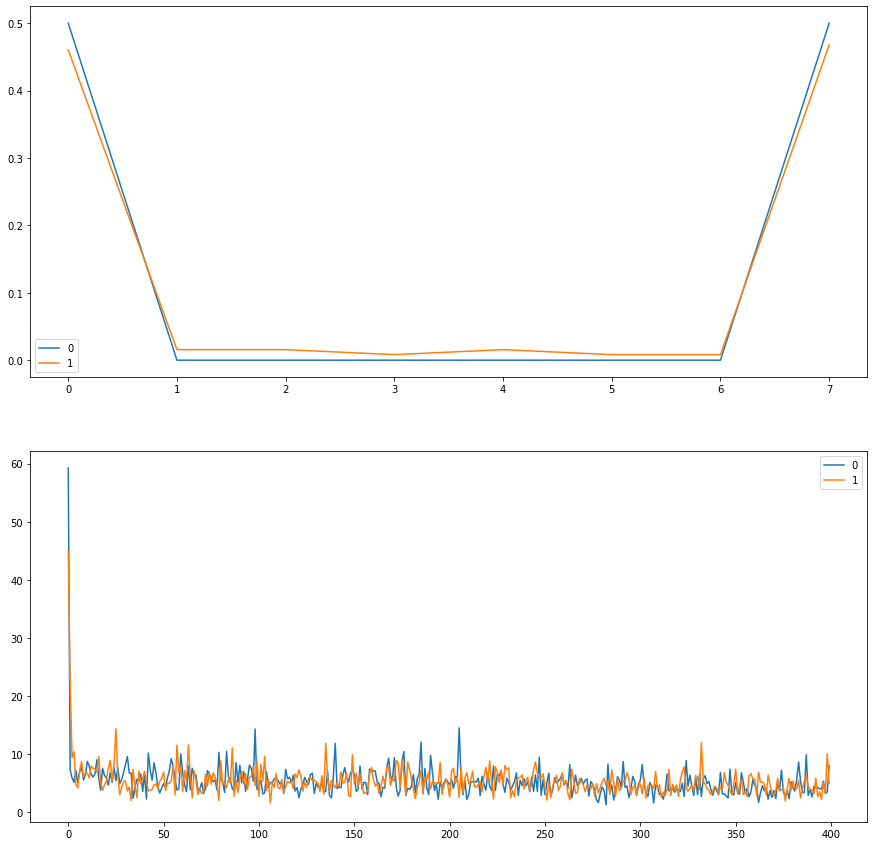

In [116]:
#here we do the training
fig, (ax1, ax2) = plt.subplots(2,figsize=(15,15))

learners = []
for i in range(2):
  gen = generators[i]
  ax1.plot(gen.new_probabilities(), label = i)
  lner = Learner(gen.train_data, gen.test_data, 4000, 0.01)
  lner.train()
  learners.append(lner)
  parameter[1,0] = parameter[1,0] + pi/10
  print(parameter)
  ax2.plot(lner.losses, label = i)

ax1.legend()
ax2.legend()

tensor([10.2138]) tensor(9.7733)
tensor([7.0077]) tensor(7.8483)
tensor([5.8425]) tensor(7.3097)
tensor([7.3402]) tensor(6.7987)
tensor([9.7470]) tensor(9.6764)
tensor([6.3584]) tensor(7.8942)
tensor([6.4452]) tensor(9.9626)
tensor([6.1294]) tensor(6.2249)
tensor([6.2671]) tensor(9.0437)
tensor([5.9859]) tensor(7.9423)
tensor([7.8851]) tensor(7.9850)
tensor([4.8599]) tensor(5.5128)
tensor([6.0138]) tensor(6.9492)
tensor([6.6094]) tensor(7.4624)
tensor([5.7575]) tensor(5.2278)
tensor([7.3352]) tensor(4.2589)
tensor([6.3794]) tensor(4.7160)
tensor([8.1566]) tensor(7.2346)
tensor([6.6623]) tensor(5.4073)
tensor([6.3531]) tensor(8.6511)
tensor([6.5522]) tensor(4.4870)
tensor([5.1302]) tensor(0.6824)
tensor([6.5480]) tensor(8.6005)
tensor([8.6835]) tensor(9.3666)
tensor([6.8075]) tensor(7.5556)
tensor([11.2453]) tensor(10.2055)
tensor([7.6892]) tensor(8.5782)
tensor([6.3576]) tensor(7.7823)
tensor([5.3116]) tensor(3.5483)
tensor([6.6027]) tensor(4.5518)


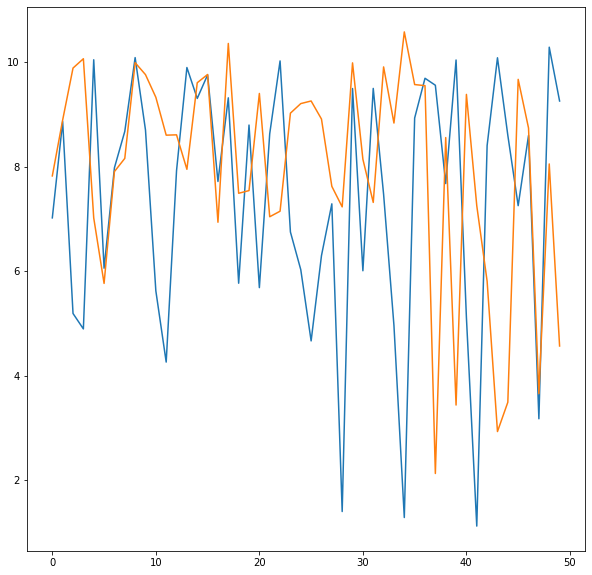

In [117]:
lner = learners[0]
for i in range(30):
    print(lner.model(lner.test_data[i, 0: 9]).detach_(), lner.test_data[i, 9])

for i in range(len(generators)):
    plt.plot(generators[i].train_data[0:50, 9], label = i)

In [ ]:
])